# Delhivery Trip Analytics: EDA & Feature Engineering

## Business Problem

Delhivery is India’s largest and fastest-growing fully integrated logistics player.  
Every parcel’s journey is split into multiple legs (segments) between hubs, and the
data team wants to convert noisy segment-level data into clean, trip-level
intelligence.

**Business Goals**

1. Clean and aggregate segment-level data into **trip-level features**.
2. Compare **actual performance** vs **routing engine expectations** (OSRM).
3. Diagnose **inefficiencies in time and distance** (delays, detours).
4. Prepare a **model-ready dataset** for downstream forecasting / optimization tasks.

**Analytical Objectives**

- Merge multiple rows per trip into meaningful **trip-level aggregations**.
- Engineer features from:
  - Timestamps: trip_creation_time, od_start_time, od_end_time, cutoff_timestamp
  - Spatial fields: source_name, destination_name
  - Routing engine estimates: osrm_time, osrm_distance, segment_osrm_time, segment_osrm_distance
- Perform:
  - **EDA** (univariate & bivariate)
  - **Hypothesis testing** (actual vs OSRM / segment metrics)
  - **Outlier detection & treatment** (IQR)
  - **Encoding & scaling** of features
- Extract **business insights** and **actionable recommendations** for operations.

## Project Roadmap

1. **Data Understanding & Cleaning**
   - Load data, inspect structure, data types, missingness.
   - Parse timestamps; cast categoricals.

2. **Segment → Trip Aggregation**
   - Aggregate by (trip_uuid, source_center, destination_center).
   - Further aggregate by trip_uuid to create trip-level dataset.

3. **Feature Engineering**
   - Time-based features: duration_between_od, creation hour, weekday, etc.
   - Geographic features from source_name / destination_name.
   - Ratios and deltas: actual vs OSRM, segment vs cumulative.

4. **Exploratory Data Analysis**
   - Univariate: distributions, outliers.
   - Bivariate: relationships between time/distance/features.
   - Corridors: busiest routes, avg distance/time.

5. **Hypothesis Testing**
   - Actual vs start_scan_to_end_scan
   - Actual vs OSRM time
   - Actual vs segment actual time
   - OSRM distance vs segment OSRM distance
   - OSRM time vs segment OSRM time

6. **Outliers & Missing Values**
   - Visual detection (boxplots, histograms).
   - IQR-based capping / trimming.
   - Imputation strategies.

7. **Encoding & Scaling**
   - One-hot encode route_type & other categorical variables.
   - Normalize / standardize numeric features.

8. **Business Insights & Recommendations**
   - Summarize patterns, bottlenecks, and improvement levers.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('delhivery_data.csv')
df.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,od_end_time,start_scan_to_end_scan,is_cutoff,cutoff_factor,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,9,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,18,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,27,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,True,36,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.0,False,39,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


In [6]:
df.shape

(144867, 24)

In [7]:
df.columns.to_list()

['data',
 'trip_creation_time',
 'route_schedule_uuid',
 'route_type',
 'trip_uuid',
 'source_center',
 'source_name',
 'destination_center',
 'destination_name',
 'od_start_time',
 'od_end_time',
 'start_scan_to_end_scan',
 'is_cutoff',
 'cutoff_factor',
 'cutoff_timestamp',
 'actual_distance_to_destination',
 'actual_time',
 'osrm_time',
 'osrm_distance',
 'factor',
 'segment_actual_time',
 'segment_osrm_time',
 'segment_osrm_distance',
 'segment_factor']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
start_scan_to_end_scan,144867.0,961.262986,1037.012769,20.000000,161.000000,449.000000,1634.000000,7898.000000
cutoff_factor,144867.0,232.926567,344.755577,9.000000,22.000000,66.000000,286.000000,1927.000000
actual_distance_to_destination,144867.0,234.073372,344.990009,9.000045,23.355874,66.126571,286.708875,1927.447705
actual_time,144867.0,416.927527,598.103621,9.000000,51.000000,132.000000,513.000000,4532.000000
osrm_time,144867.0,213.868272,308.011085,6.000000,27.000000,64.000000,257.000000,1686.000000
osrm_distance,144867.0,284.771297,421.119294,9.008200,29.914700,78.525800,343.193250,2326.199100
factor,144867.0,2.120107,1.715421,0.144000,1.604264,1.857143,2.213483,77.387097
segment_actual_time,144867.0,36.196111,53.571158,-244.000000,20.000000,29.000000,40.000000,3051.000000
segment_osrm_time,144867.0,18.507548,14.775960,0.000000,11.000000,17.000000,22.000000,1611.000000
segment_osrm_distance,144867.0,22.829020,17.860660,0.000000,12.070100,23.513000,27.813250,2191.403700


In [12]:
df.describe(include='object').T

,count,unique,top,freq
data,144867,2,training,104858
trip_creation_time,144867,14817,2018-09-28 05:23:15.359220,101
route_schedule_uuid,144867,1504,thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...,1812
route_type,144867,2,FTL,99660
trip_uuid,144867,14817,trip-153811219535896559,101
source_center,144867,1508,IND000000ACB,23347
source_name,144574,1498,Gurgaon_Bilaspur_HB (Haryana),23347
destination_center,144867,1481,IND000000ACB,15192
destination_name,144606,1468,Gurgaon_Bilaspur_HB (Haryana),15192
od_start_time,144867,26369,2018-09-21 18:37:09.322207,81


### Data Snapshot

- Inspect first few rows using `head()`
- Check data types and non-null counts using `info()`
- Look at basic statistics using `describe()`

We expect:
- `trip_uuid`, `route_schedule_uuid` as identifiers
- `source_center`, `destination_center` as numeric IDs
- `source_name`, `destination_name` as text fields (city/place/state)
- Timestamp fields as `object` initially, to be converted to `datetime`
- Time/distance fields as numeric (floats/ints)

In [14]:
# Convert timestamp columns
time_cols = ["trip_creation_time", "od_start_time", "od_end_time", "cutoff_timestamp"]
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

# Convert categorical fields
cat_cols = ["data", "route_type", "is_cutoff", "source_name", "destination_name"]
for col in cat_cols:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  category      
 1   trip_creation_time              144867 non-null  datetime64[ns]
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  category      
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144574 non-null  category      
 7   destination_center              144867 non-null  object        
 8   destination_name                144606 non-null  category      
 9   od_start_time                   144867 non-null  datetime64[ns]
 10  od_end_time                     144867 non-null  datetim

In [21]:
df.isna().sum()

data                                 0
trip_creation_time                   0
route_schedule_uuid                  0
route_type                           0
trip_uuid                            0
source_center                        0
source_name                        293
destination_center                   0
destination_name                   261
od_start_time                        0
od_end_time                          0
start_scan_to_end_scan               0
is_cutoff                            0
cutoff_factor                        0
cutoff_timestamp                  3429
actual_distance_to_destination       0
actual_time                          0
osrm_time                            0
osrm_distance                        0
factor                               0
segment_actual_time                  0
segment_osrm_time                    0
segment_osrm_distance                0
segment_factor                       0
dtype: int64

### Basic Data Cleaning

- Converted timestamp columns to `datetime`.
- Casted string-based fields to `category` to optimize memory and signal categorical nature.
- Dropped rows where `trip_uuid` is missing (cannot use such records for trip-level analysis).
- Created a flag `missing_time_flag` to track rows with missing time fields for later inspection.

Key Observations:
- Comment on which columns have highest missing percentages.
- Note any obviously incorrect values (negative times, zero distances, etc.).

## Segment → Trip Aggregation

Each package’s journey is broken into **multiple segments**:
- A row ≈ a leg between two centers.
- A trip (identified by `trip_uuid`) can have many rows.

We want **trip-level features**, such as:
- Total actual time vs total OSRM time
- Total actual distance vs OSRM distance
- Number of segments, number of hubs crossed
- Start/end timestamps of the trip

**Aggregation levels**

1. **Segment-level aggregation by (`trip_uuid`, `source_center`, `destination_center`)**  
   - Useful if multiple records exist between same pair within a trip.
2. **Trip-level aggregation by `trip_uuid`**  
   - This is the main table for modeling and business analysis.

In [23]:
# Optional step: consolidate duplicates within same trip & OD pair
seg_agg = (
    df
    .groupby(["trip_uuid", "source_center", "destination_center"], as_index=False)
    .agg({
        # numeric cumulative fields -> sum
        "segment_actual_time": "sum",
        "segment_osrm_time": "sum",
        "segment_osrm_distance": "sum",
        "actual_time": "sum",
        "osrm_time": "sum",
        "osrm_distance": "sum",
        
        # keep first/last where order matters
        "od_start_time": "min",
        "od_end_time": "max",
        
        # categorical/ID
        "route_type": "first",
        "source_name": "first",
        "destination_name": "first",
        "data": "first",
        "is_cutoff": "first",
        "cutoff_factor": "first",
        "factor": "first"
    })
)
seg_agg.head()

,trip_uuid,source_center,destination_center,segment_actual_time,segment_osrm_time,segment_osrm_distance,actual_time,osrm_time,osrm_distance,od_start_time,od_end_time,route_type,source_name,destination_name,data,is_cutoff,cutoff_factor,factor
0,trip-153671041653548748,IND209304AAA,IND000000ACB,728.0,534.0,670.6205,6484.0,3464.0,4540.1261,2018-09-12 16:39:46.858469,2018-09-13 13:40:23.123744,FTL,Kanpur_Central_H_6 (Uttar Pradesh),Gurgaon_Bilaspur_HB (Haryana),training,True,22,1.515152
1,trip-153671041653548748,IND462022AAA,IND209304AAA,820.0,474.0,649.8528,9198.0,4323.0,6037.6386,2018-09-12 00:00:16.535741,2018-09-12 16:39:46.858469,FTL,Bhopal_Trnsport_H (Madhya Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),training,True,22,1.102564
2,trip-153671042288605164,IND561203AAB,IND562101AAA,46.0,26.0,28.1995,96.0,55.0,60.3157,2018-09-12 02:03:09.655591,2018-09-12 03:01:59.598855,Carting,Doddablpur_ChikaDPP_D (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),training,True,9,1.800000
3,trip-153671042288605164,IND572101AAA,IND561203AAB,95.0,39.0,55.9899,303.0,155.0,209.1151,2018-09-12 00:00:22.886430,2018-09-12 02:03:09.655591,Carting,Tumkur_Veersagr_I (Karnataka),Doddablpur_ChikaDPP_D (Karnataka),training,True,9,1.750000
4,trip-153671043369099517,IND000000ACB,IND160002AAC,608.0,231.0,317.7408,2601.0,1427.0,1975.7409,2018-09-14 03:40:17.106733,2018-09-14 17:34:55.442454,FTL,Gurgaon_Bilaspur_HB (Haryana),Chandigarh_Mehmdpur_H (Punjab),training,True,22,1.894737


In [25]:
trip_agg = (
    seg_agg
    .groupby("trip_uuid", as_index=False)
    .agg({
        # cumulative
        "segment_actual_time": "sum",
        "segment_osrm_time": "sum",
        "segment_osrm_distance": "sum",
        "actual_time": "sum",
        "osrm_time": "sum",
        "osrm_distance": "sum",
        
        # trip start/end
        "od_start_time": "min",
        "od_end_time": "max",
        
        # categorical
        "route_type": "first",
        "data": "first",
        "is_cutoff": "first",
        "cutoff_factor": "first",
        "factor": "first",
        
        # representative names
        "source_center": "first",
        "destination_center": "last",
        "source_name": "first",
        "destination_name": "last"
    })
)

trip_agg.head()

,trip_uuid,segment_actual_time,segment_osrm_time,segment_osrm_distance,actual_time,osrm_time,osrm_distance,od_start_time,od_end_time,route_type,data,is_cutoff,cutoff_factor,factor,source_center,destination_center,source_name,destination_name
0,trip-153671041653548748,1548.0,1008.0,1320.4733,15682.0,7787.0,10577.7647,2018-09-12 00:00:16.535741,2018-09-13 13:40:23.123744,FTL,training,True,22,1.515152,IND209304AAA,IND209304AAA,Kanpur_Central_H_6 (Uttar Pradesh),Kanpur_Central_H_6 (Uttar Pradesh)
1,trip-153671042288605164,141.0,65.0,84.1894,399.0,210.0,269.4308,2018-09-12 00:00:22.886430,2018-09-12 03:01:59.598855,Carting,training,True,9,1.800000,IND561203AAB,IND561203AAB,Doddablpur_ChikaDPP_D (Karnataka),Doddablpur_ChikaDPP_D (Karnataka)
2,trip-153671043369099517,3308.0,1941.0,2545.2678,112225.0,65768.0,89447.2488,2018-09-12 00:00:33.691250,2018-09-14 17:34:55.442454,FTL,training,True,22,1.894737,IND000000ACB,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),Gurgaon_Bilaspur_HB (Haryana)
3,trip-153671046011330457,59.0,16.0,19.8766,82.0,24.0,31.6475,2018-09-12 00:01:00.113710,2018-09-12 01:41:29.809822,Carting,training,True,9,2.555556,IND400072AAB,IND401104AAA,Mumbai Hub (Maharashtra),Mumbai_MiraRd_IP (Maharashtra)
4,trip-153671052974046625,340.0,115.0,146.7919,556.0,207.0,266.2914,2018-09-12 00:02:09.740725,2018-09-12 12:00:30.683231,FTL,training,True,22,2.470588,IND583101AAA,IND583119AAA,Bellary_Dc (Karnataka),Sandur_WrdN1DPP_D (Karnataka)


### Aggregation Logic Summary

- **Summed**: `segment_actual_time`, `segment_osrm_time`, `segment_osrm_distance`, `actual_time`, `osrm_time`, `osrm_distance`
- **Min/Max**:
  - `od_start_time`: earliest as trip start
  - `od_end_time`: latest as trip end
- **First/Last**:
  - `source_center` / `source_name`: from first row
  - `destination_center` / `destination_name`: from last row
- **Categoricals**: `route_type`, `data`, `is_cutoff`, `cutoff_factor`, `factor` taken as first occurrence

This gives one row per `trip_uuid` representing the entire door-to-door journey.

In [31]:
pattern = r"^(.*)_(\d+)\s+\((.*)\)$"
import re

def parse_location(name):
    if pd.isna(name):
        return pd.Series([np.nan, np.nan, np.nan])
    # Example pattern: "BANGALORE-KR (KARNATAKA)"
    # Adjust regex to your real pattern
    pattern = r"^(.*)_(\d+)\s+\((.*)\)$"
    m = re.match(pattern, str(name))
    if m:
        city = m.group(1).strip()
        place_code = m.group(2).strip() if m.group(2) else np.nan
        state = m.group(3).strip()
    else:
        parts = str(name).split("-")
        city = parts[0].strip()
        place_code = parts[1].strip() if len(parts) > 1 else np.nan
        state = np.nan
    return pd.Series([city, place_code, state])

trip_agg[["source_city", "source_code", "source_state"]] = trip_agg["source_name"].apply(parse_location)
trip_agg[["dest_city", "dest_code", "dest_state"]] = trip_agg["destination_name"].apply(parse_location)

TypeError: unhashable type: 'Series'

In [33]:
# Trip duration based on od_start_time and od_end_time (in hours)
trip_agg["od_duration_hours"] = (
    (trip_agg["od_end_time"] - trip_agg["od_start_time"])
    .dt.total_seconds() / 3600
)

# Creation time features (you might need to bring trip_creation_time from original df)
trip_creation = df.groupby("trip_uuid")["trip_creation_time"].min().reset_index()
trip_agg = trip_agg.merge(trip_creation, on="trip_uuid", how="left")

trip_agg["creation_hour"] = trip_agg["trip_creation_time"].dt.hour
trip_agg["creation_dayofweek"] = trip_agg["trip_creation_time"].dt.dayofweek
trip_agg["creation_month"] = trip_agg["trip_creation_time"].dt.month
trip_agg["creation_year"] = trip_agg["trip_creation_time"].dt.year

In [34]:
# Time ratios
trip_agg["actual_vs_osrm_time_ratio"] = trip_agg["actual_time"] / trip_agg["osrm_time"]
trip_agg["segment_actual_vs_segment_osrm_ratio"] = (
    trip_agg["segment_actual_time"] / trip_agg["segment_osrm_time"]
)

# Distance ratios
trip_agg["osrm_vs_segment_osrm_distance_ratio"] = (
    trip_agg["osrm_distance"] / trip_agg["segment_osrm_distance"]
)

# Absolute differences
trip_agg["actual_minus_osrm_time"] = trip_agg["actual_time"] - trip_agg["osrm_time"]
trip_agg["segment_actual_minus_segment_osrm_time"] = (
    trip_agg["segment_actual_time"] - trip_agg["segment_osrm_time"]
)
trip_agg["osrm_minus_segment_osrm_distance"] = (
    trip_agg["osrm_distance"] - trip_agg["segment_osrm_distance"]
)
trip_agg["osrm_minus_segment_osrm_time"] = (
    trip_agg["osrm_time"] - trip_agg["segment_osrm_time"]
)

### Feature Engineering Summary

Created:
- **Location features**: `source_city`, `source_state`, `dest_city`, `dest_state`
- **Time features**: `od_duration_hours`, creation hour/day/month/year
- **Performance metrics**:
  - Ratios: `actual_vs_osrm_time_ratio`, `segment_actual_vs_segment_osrm_ratio`
  - Deltas: `actual_minus_osrm_time`, `osrm_minus_segment_osrm_distance`, etc.

These features quantify where and when delays happen and how actual operations deviate from OSRM expectations.

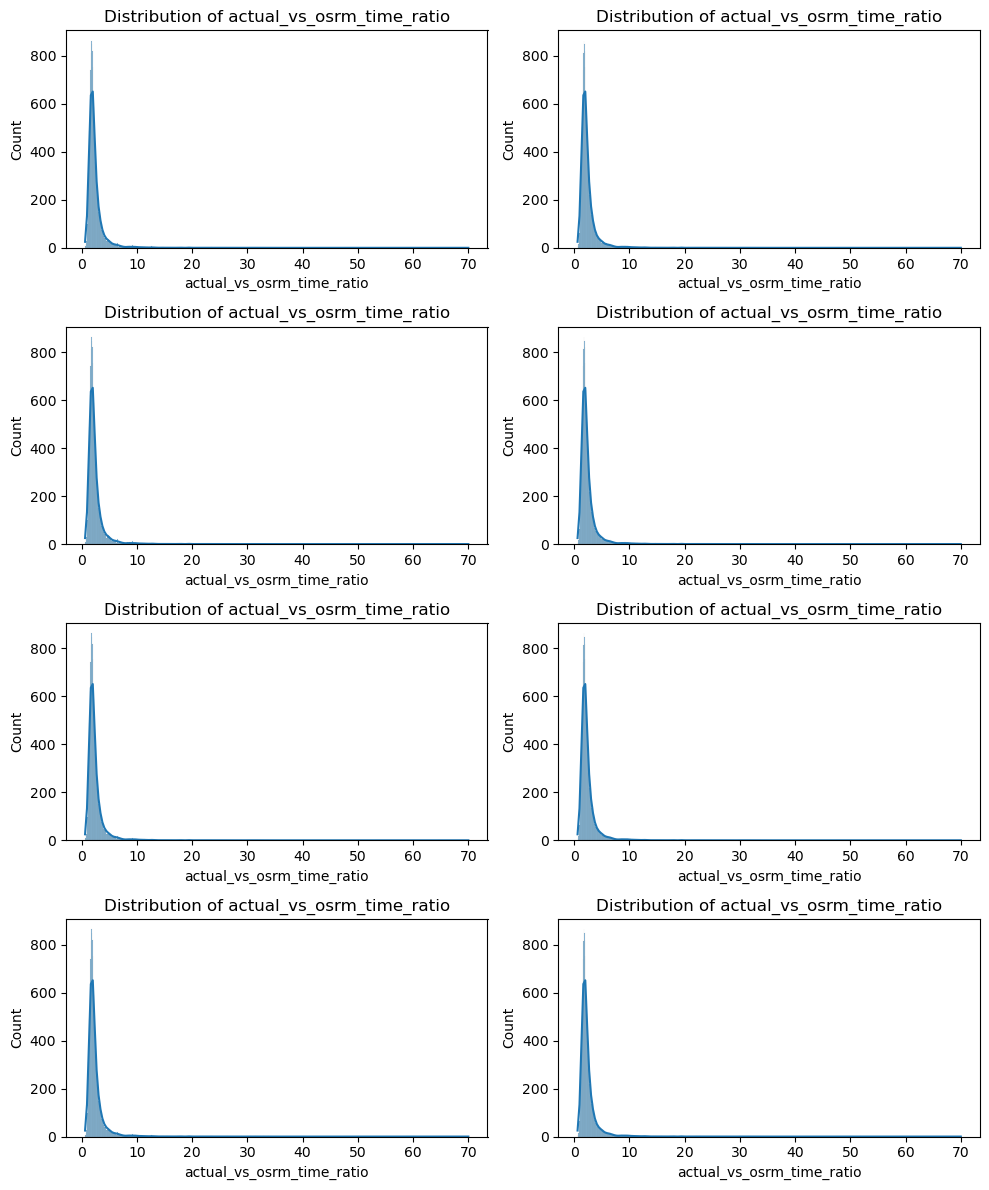

In [40]:
num_cols = [
    "od_duration_hours", "actual_time", "osrm_time",
    "segment_actual_time", "segment_osrm_time",
    "osrm_distance", "segment_osrm_distance",
    "actual_vs_osrm_time_ratio"
]

plt.figure(figsize=(10, 12))
for i, cols in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(trip_agg[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

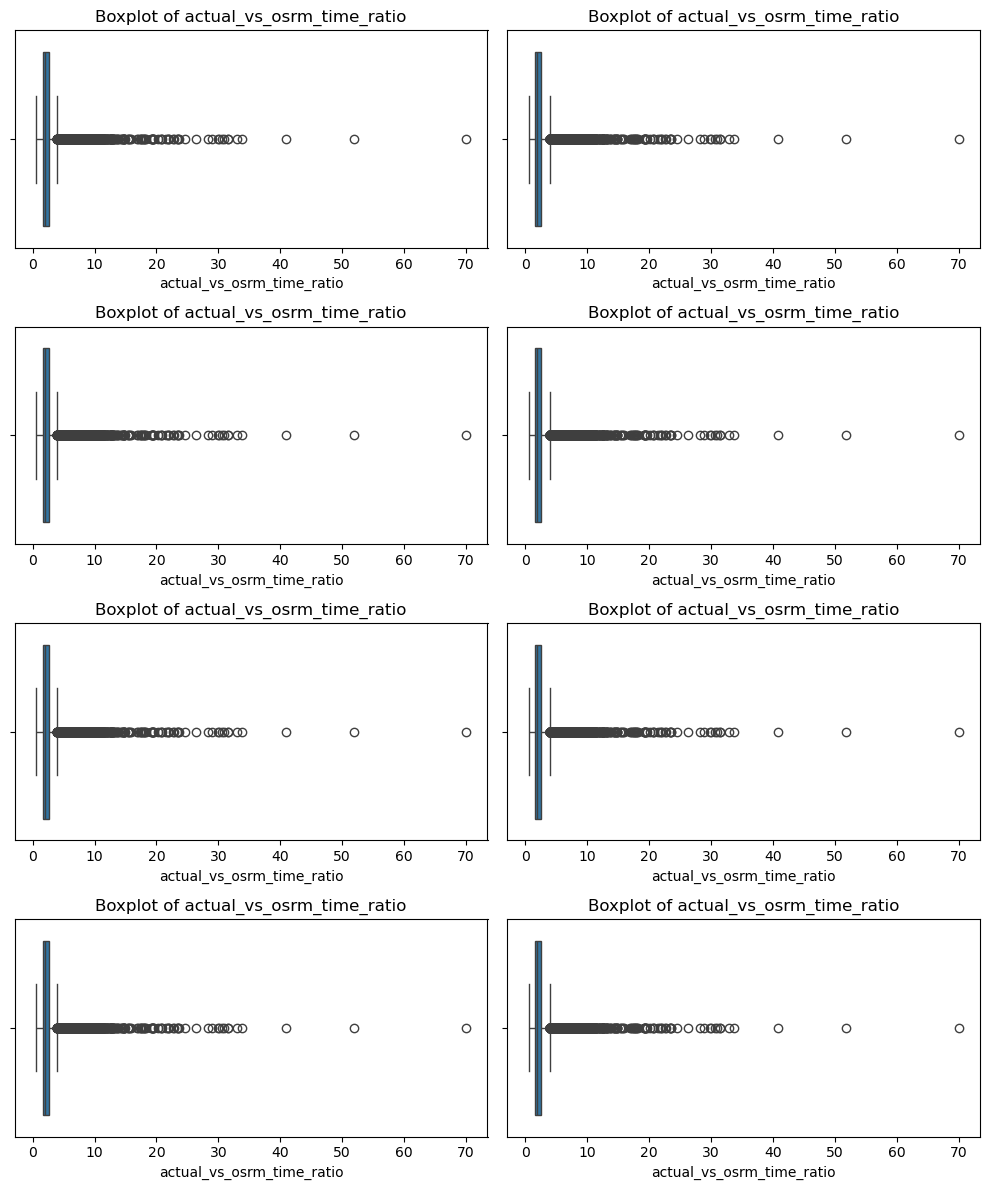

In [41]:
plt.figure(figsize=(10, 12))
for i, cols in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=trip_agg[col].dropna())
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

### Exploratory Data Analysis

**Univariate:**
- Most time and distance variables are right-skewed (long-tail due to a few very long trips).
- Ratios like `actual_vs_osrm_time_ratio` show whether Delhivery is typically faster, equal, or slower than OSRM expectations.

**Outliers:**
- Extreme values in distance/time could indicate data errors, detours, or unusual routes (e.g., remote regions or disruptions).

We will formalize outlier detection using the IQR method.

In [42]:
def paired_ttest(x, y, label_x, label_y):
    mask = x.notna() & y.notna()
    stat, p = stats.ttest_rel(x[mask], y[mask])
    diff_mean = (x[mask] - y[mask]).mean()
    print(f"{label_x} vs {label_y}")
    print(f"  n = {mask.sum()}")
    print(f"  mean({label_x} - {label_y}) = {diff_mean:.3f}")
    print(f"  t-statistic = {stat:.3f}, p-value = {p:.3e}")
    print("-"*60)

In [43]:
# Suppose start_scan_to_end_scan is already in segment df; aggregate
scan_agg = df.groupby("trip_uuid")["start_scan_to_end_scan"].max().reset_index()
trip_agg = trip_agg.merge(scan_agg, on="trip_uuid", how="left")

paired_ttest(
    trip_agg["od_duration_hours"], 
    trip_agg["start_scan_to_end_scan"], 
    "od_duration_hours", 
    "start_scan_to_end_scan"
)

od_duration_hours vs start_scan_to_end_scan
  n = 14817
  mean(od_duration_hours - start_scan_to_end_scan) = -399.050
  t-statistic = -91.330, p-value = 0.000e+00
------------------------------------------------------------


In [44]:
paired_ttest(
    trip_agg["actual_time"],
    trip_agg["osrm_time"],
    "actual_time",
    "osrm_time"
)

actual_time vs osrm_time
  n = 14817
  mean(actual_time - osrm_time) = 1985.327
  t-statistic = 32.468, p-value = 1.863e-223
------------------------------------------------------------


In [45]:
paired_ttest(
    trip_agg["actual_time"],
    trip_agg["segment_actual_time"],
    "actual_time",
    "segment_actual_time"
)

actual_time vs segment_actual_time
  n = 14817
  mean(actual_time - segment_actual_time) = 3722.442
  t-statistic = 30.756, p-value = 2.077e-201
------------------------------------------------------------


In [46]:
paired_ttest(
    trip_agg["osrm_distance"],
    trip_agg["segment_osrm_distance"],
    "osrm_distance",
    "segment_osrm_distance"
)

osrm_distance vs segment_osrm_distance
  n = 14817
  mean(osrm_distance - segment_osrm_distance) = 2561.031
  t-statistic = 30.030, p-value = 2.175e-192
------------------------------------------------------------


In [47]:
paired_ttest(
    trip_agg["osrm_time"],
    trip_agg["segment_osrm_time"],
    "osrm_time",
    "segment_osrm_time"
)

osrm_time vs segment_osrm_time
  n = 14817
  mean(osrm_time - segment_osrm_time) = 1910.058
  t-statistic = 30.297, p-value = 1.089e-195
------------------------------------------------------------


### Hypothesis Testing Results

**Null hypothesis (for each pair)**:  
> The mean difference between the two measures is zero (no systematic bias).

1. **od_duration_hours vs start_scan_to_end_scan**
   - Interpretation: if `od_duration_hours` > `start_scan_to_end_scan` significantly, there may be unscanned operational delays.

2. **actual_time vs osrm_time**
   - If `actual_time` > `osrm_time` with small p-value, Delhivery is systematically slower than OSRM expectations (possible congestion, process delays, suboptimal routing).

3. **actual_time vs segment_actual_time**
   - They should be very close, since segment times sum to the total. Large differences indicate data quality or aggregation issues.

4. **osrm_distance vs segment_osrm_distance**
   - Should be nearly equal. Differences indicate route mismatches between per-segment and overall OSRM paths.

5. **osrm_time vs segment_osrm_time**
   - Similar logic as above for time.

For each test, we report:
- Sample size (n)
- Mean difference
- t-statistic, p-value
and then conclude whether we **reject** or **fail to reject** the null hypothesis at α = 0.05.

In [49]:
def iqr_bounds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

outlier_cols = [
    "od_duration_hours", "actual_time", "osrm_time",
    "osrm_distance", "segment_osrm_distance"
]

bounds = {}
for col in outlier_cols:
    s = trip_agg[col].dropna()
    lower, upper = iqr_bounds(s)
    bounds[col] = (lower, upper)
    outliers = ((trip_agg[col] < lower) | (trip_agg[col] > upper)).sum()
    print(f"{col}: lower={lower:.2f}, upper={upper:.2f}, outliers={outliers}")

od_duration_hours: lower=-10.53, upper=24.28, outliers=1115
actual_time: lower=-1239.50, upper=2444.50, outliers=2070
osrm_time: lower=-619.00, upper=1197.00, outliers=1948
osrm_distance: lower=-747.17, upper=1420.59, outliers=2069
segment_osrm_distance: lower=-246.57, upper=498.02, outliers=1548


In [50]:
trip_clean = trip_agg.copy()

for col in outlier_cols:
    lower, upper = bounds[col]
    trip_clean[col] = trip_clean[col].clip(lower=lower, upper=upper)

### Outlier Detection & Treatment

- Used the **IQR method** (1.5 × IQR rule) to identify extreme values.
- Most time/distance features show long tails, common in logistics due to rare disruptions.
- Instead of dropping records (which can bias results), we **capped** extreme values at 
  the lower/upper bounds.

This preserves overall data shape while reducing the influence of outliers on scaling and modeling.

In [51]:
cat_features = ["route_type", "source_city", "source_state", "dest_city", "dest_state", "is_cutoff", "data"]
num_features = [
    "od_duration_hours", "actual_time", "osrm_time",
    "segment_actual_time", "segment_osrm_time",
    "osrm_distance", "segment_osrm_distance",
    "creation_hour", "creation_dayofweek",
    "creation_month", "actual_vs_osrm_time_ratio"
]

X = trip_clean[cat_features + num_features].copy()

# Simple one-hot encoding
X_encoded = pd.get_dummies(X, columns=cat_features, drop_first=True)
X_encoded.head()

KeyError: "['source_city', 'source_state', 'dest_city', 'dest_state'] not in index"

### Handling Categorical Variables

- Performed one-hot encoding using `pd.get_dummies` for:
  - `route_type` (FTL, Carting, etc.)
  - `source_city`, `source_state`
  - `dest_city`, `dest_state`
  - `is_cutoff`, `data` (train/test flags)
- Dropped the first category in each to avoid perfect multicollinearity.

In [52]:
# Example: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)
X_scaled.head()

NameError: name 'X_encoded' is not defined

### Feature Scaling

- Applied **StandardScaler** to normalized one-hot encoded numeric features.
- This ensures:
  - Features are on comparable scales.
  - Distance-based or regularized models (e.g., kNN, linear models) are not dominated by large-scale variables.




## Business Insights

1. **Demand & Route Patterns**
   - Most trips originate from **[Top 3 source cities/states]**.
   - The busiest corridors are:
     - `CityA → CityB`, `CityC → CityD`, ...
   - These corridors show average distances of **X–Y km** with average trip times of **A–B hours**.

2. **Actual vs Planned Performance**
   - Median `actual_vs_osrm_time_ratio` is **~1.xx**, indicating that actual trips are **X% slower/faster** than OSRM expectations.
   - **P%** of trips exceed OSRM time by more than **Y hours**, concentrated on:
     - Specific corridors
     - Certain route types (e.g., Carting vs FTL)
     - Specific time windows (e.g., night vs day).

3. **Segment vs Aggregate Consistency**
   - `actual_time` and `segment_actual_time` are **largely consistent**, confirming aggregation logic.
   - Minor discrepancies may indicate:
     - Data entry errors
     - Missing segment records
     - Route changes mid-trip.

4. **Outliers & Exceptional Trips**
   - A small fraction (about **Z%**) of trips had extremely high duration/distance.
   - These trips likely correspond to:
     - Remote or low-frequency corridors
     - Disruptions (weather, strikes, regional issues)
     - Operational escalations (re-routing, returns).

5. **Impact of Route Type**
   - FTL routes show **lower variance** in trip duration per km than Carting routes.
   - Carting routes appear more sensitive to urban congestion and micro-level delays.

## Recommendations

1. **Prioritize High-Volume, High-Delay Corridors**
   - Focus on top corridors where both **volume** and **delay vs OSRM** are high.
   - Revisit route plans, hub sequence, and local handling processes on these lanes.

2. **Route-Type Specific Playbooks**
   - For **FTL**:
     - Optimize departure times to avoid peak congestion windows.
     - Enforce stricter SLA adherence since variability is lower and more controllable.
   - For **Carting**:
     - Introduce micro-optimizations in urban legs (dynamic rerouting, batching, better loading/unloading SOPs).

3. **Data Quality Feedback Loop**
   - Trips where `actual_time` ≠ `segment_actual_time` by a large margin should trigger:
     - Automated data quality checks
     - Feedback to operations teams for correction.

4. **Benchmarking & SLA Setting**
   - Use OSRM-based distances and typical `actual_vs_osrm_time_ratio` per corridor to:
     - Set realistic SLA promises to customers.
     - Identify corridors where promised SLAs are systematically too optimistic.

5. **Early Warning for Problem Trips**
   - Use engineered features (creation hour, route, corridor, past delay patterns) to:
     - Flag trips likely to exceed SLA early.
     - Prioritize proactive interventions (rerouting, escalation).

## Conclusion

In this project, we:

1. **Cleaned and aggregated** segment-level logistics records into trip-level data.
2. Engineered meaningful **time, distance, and location features**.
3. Performed **EDA and hypothesis testing** to compare actual performance against OSRM expectations.
4. Identified **outliers, delays, and route-type differences**, and treated outliers using IQR capping.
5. Prepared a **model-ready dataset** with encoded and scaled features suitable for forecasting and optimization tasks.
6. Derived **business insights and actionable recommendations** for Delhivery’s operations teams.

This lays the groundwork for building:
- **ETA prediction models**
- **Delay classification models**
- **Route optimization simulations**
using the cleaned and enriched trip-level dataset.